# Analyse data from computations on cluster

sampling ensembles with all the $^3 J$ scalar couplings

In [1]:
import os, pandas
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

#### currently-defined functions

In [2]:
def save_dict_to_txt(my_dict, txt_path, sep : str=' '):
    """
    Save a dictionary as a txt file with column names given by indicization of dict keys.
    Each item value should be 0- or 1-dimensional (either int, float, np.ndarray or list),
    not 2-dimensional or more.
    """

    header = []
    values = []

    for key, arr in my_dict.items():
        if (type(arr) is int) or (type(arr) is float):
            header.append(key)
            values.append(arr)
        else:
            # assert ((type(arr) is np.ndarray) and (len(arr.shape) == 1)) or (type(arr) is list), 'error on element with key %s' % key
            # you could also have jax arrays, so manage as follows:

            try:
                l = len(arr.shape)
            except:
                l = 0
            assert (l == 1) or (type(arr) is list), 'error on element with key %s' % key
            
            # you should also check that each element in the list is 1-dimensional
            for i, val in enumerate(arr, 1):
                header.append(f"{key}_{i}")
                values.append(val)

    with open(txt_path, 'w') as f:
        f.write(sep.join(header) + '\n')
        f.write(sep.join(str(v) for v in values) + '\n')

    return

In [3]:
def detect_convergence(time_series, threshold_fact = 50., which_method = 1, if_plot = False):
    """
    There are several ways to detect convergence of a time series (beyond visual inspection),
    for example you can compute averages on time windows and then compare them.
    Here, `threshold_fact` is not required.

    Alternatively (`which_method = 2`), we can compute the variation of the cumulative averages
    and check where it goes under a threshold. This variation is equal to:

    $ \delta m(j) = m(j + 1) - m(j) = ... = 1/(j + 1) * (x_{j+1} - m(j))$

    where $m(j)$ is the cumulative average up to frame n. $j$.
    """

    time_series = np.asarray(time_series)

    if which_method == 1:
        std = np.std(time_series[-5000:])
        diffs = np.abs(time_series - time_series[-1])/std
        wh = np.argwhere(diffs < 7)

        b = ( len(wh)/len(diffs) > 0.99 )
        # this is to avoid sporadic deviations above the threshold will affect the convergence detection

        if b : position = 0
        else : position = wh[np.where(np.ediff1d(wh) != 1)][-1][0]

        if if_plot:
            plt.figure()
            plt.plot(diffs)
            plt.plot([0, len(diffs)], 7*np.ones(2), 'k')

        return position

    elif which_method == 2:
        cumulative_avg = np.cumsum(time_series) / np.arange(1, len(time_series) + 1)
        diff = np.ediff1d(cumulative_avg)

        my_max = np.max(diff)
        threshold = my_max/threshold_fact

        wh = np.argwhere(diff < threshold)
        b = ( wh[-1] == len(diff) - 1 )[0]

        if if_plot:
            plt.figure()
            plt.plot(diff)
            plt.plot([0, len(diff)], threshold*np.ones(2))
            plt.title('diff')

        if b :
            position = wh[np.where(np.ediff1d(wh) != 1)][-1][0]
            print('convergence found at %s' % position)
            return position
        else:
            print('convergence not detected')
            return None 


In [4]:
class My_mean_and_std_Result():
    def __init__(self, inds, avs, stds):
        self.inds = inds
        self.avs = avs
        self.stds = stds

def my_mean_and_std(time_series, if_detect_convergence = False):
    if not if_detect_convergence:
        avs = np.mean(time_series, axis=0)
        stds = np.std(time_series, axis=0)
        inds = None
    else:
        if len(time_series.shape) == 1:
            ind = detect_convergence(time_series)
            inds = ind
            avs = np.mean(time_series[ind:])
            stds = np.std(time_series[ind:])
        
        elif len(time_series.shape) == 2:
            inds = []
            avs = []
            stds = []

            for i in range(time_series.shape[1]):
                ind = detect_convergence(time_series[:, i])
                inds.append(ind)
                avs.append(np.mean(time_series[ind:, i]))
                stds.append(np.std(time_series[ind:, i]))

        # avs = np.array(avs)  # different lengths!!
    return My_mean_and_std_Result(inds, avs, stds)

In [5]:
def denormalize(values, normg_mean, normg_std, if_mean: bool=True):
    """
    denormalize mean (if if_mean) or standard deviation (if not if_mean)
    """
    if normg_mean is not None:
        denormalized_values = values*normg_std + normg_mean
    else:
        denormalized_values = values*normg_std
    return np.array(denormalized_values)

In [6]:
class MyData_parvalues:
    """
    from a pandas dataframe to a dictionary of class instances, without further memory required;
    in this way, you can add further properties to each class instance, beyond those in the pandas dataframe
    
    self.stride = row['stride'] → value is copied, no reference

    self._df = df + property → reference kept, reflects changes

    Defining new attributes as in the following lines will duplicate the data (twice memory will be required)
    indeed if I modify for example a value through MyData instance, the corresponding value
    in the original dataframe will not be modified
    
    for s in list(df.columns):
        setattr(self, s, df[s].loc[label])
    
    so, refer to it as reference-only: to do this we can define it as a method
    in addition, @property has specific advantages when you want an attribute-like interface with dynamic behavior:
    both dynamic computation (as method), still access it like an attribute e.g. obj.stride rather than obj.stride()
    the following lines correspond to what those containing make_getter do in each iteration
    
    @property
    def stride(self):
        return self.df.loc[self.label, 'stride']
    """
    def __init__(self, i, label, df):  # , traj, qs, ene):
        self.i = i
        self.label = label
        self.df = df  # this is just a reference (to the full dataframe), so no further memory is required

        for col in df.columns:  # also this is just a reference (see above)
            def make_getter(col):
                return property(lambda self: df.loc[self.label, col])
            
            setattr(self.__class__, col, make_getter(col))

        # row = self.df.loc[self.label]

        # for col_name, value in row.items():
        #     setattr(self, col_name, value)

        # self.stride = int(self.stride)

        # this does not work!
        # for col in df.columns:
        #     setattr(self, col, df.loc[label, col])
        
        # # these are references (you can check by modifying just one element of that, it is modified also the original one)
        # self.traj = traj
        # self.n_steps_MC = traj.shape[0]
        # self.obs = qs[:, :28]
        # self.dkl = qs[:, 28]
        # if qs.shape[1] == 30: self.loss = qs[:, 29]
        # self.energy = ene

    def get_attributes(self):
        return [s for s in dir(self) if s[:2] != '__']


class MyData(MyData_parvalues):
    def __init__(self, mydata_parvalues : MyData_parvalues, path):

        super().__init__(mydata_parvalues.i, mydata_parvalues.label, mydata_parvalues.df)  # **mydata_parvalues.__dict__)
        # in this way, an instance of `MyData_parvalues` is initialized with all the attributes
        # given by mydata_parvalues.__dict__, so no new attributes can be included to mydata_parvalues
        # beyond those already contained in its __init__ !! (otherwise return error)

        # # these are references (you can check by modifying just one element of that, it is modified also the original one)
        # # you could also directly read them from input files
        # self.traj = traj
        # self.n_steps_MC = traj.shape[0]
        # self.obs = qs[:, :28]
        # self.dkl = qs[:, 28]
        # if qs.shape[1] == 30: self.loss = qs[:, 29]
        # self.energy = ene

        self.traj = np.load(path + 'Result_' + self.label + '/trajectory.npy', mmap_mode='r')
        self.n_steps_true = self.traj.shape[0]

        qs = np.load(path + 'Result_' + self.label + '/quantities.npy', mmap_mode='r')

        self.obs = qs[:, :28]
        self.dkl = qs[:, 28]
        if qs.shape[1] == 30: self.loss = qs[:, 29]  # without non-informative prior
        self.energy = np.load(path + 'Result_' + self.label + '/energy.npy', mmap_mode='r')

        # add average values and stds computed through `my_mean_and_std`

In [7]:
# a simpler way but perhaps less effective / professional (maybe some attributes are not reference-like)

class MyData_parvalues:
    """
    from a pandas dataframe to a dictionary of class instances, without further memory required;
    in this way, you can add further properties to each class instance, beyond those in the pandas dataframe
    
    self.stride = row['stride'] → value is copied, no reference

    self._df = df + property → reference kept, reflects changes

    Defining new attributes as in the following lines will duplicate the data (twice memory will be required)
    indeed if I modify for example a value through MyData instance, the corresponding value
    in the original dataframe will not be modified
    
    for s in list(df.columns):
        setattr(self, s, df[s].loc[label])
    
    so, refer to it as reference-only: to do this we can define it as a method
    in addition, @property has specific advantages when you want an attribute-like interface with dynamic behavior:
    both dynamic computation (as method), still access it like an attribute e.g. obj.stride rather than obj.stride()
    the following lines correspond to what those containing make_getter do in each iteration
    
    @property
    def stride(self):
        return self.df.loc[self.label, 'stride']
    """
    def __init__(self, i, label, df):  # , traj, qs, ene):
        self.i = i
        self.label = label
        self.df = df  # this is just a reference (to the full dataframe), so no further memory is required

        # for col in df.columns:  # also this is just a reference (see above)
        #     def make_getter(col):
        #         return property(lambda self: df.loc[self.label, col])
            
        #     setattr(self.__class__, col, make_getter(col))

        # is this just a reference?
        row = self.df.loc[self.label]

        for col_name, value in row.items():
            setattr(self, col_name, value)

        self.stride = int(self.stride)

    def get_attributes(self):
        return [s for s in dir(self) if s[:2] != '__']


class MyData():
    def __init__(self, mydata_parvalues : MyData_parvalues, path):

        for item in vars(mydata_parvalues).items():
            setattr(self, item[0], item[1])

        # # these are references (you can check by modifying just one element of that, it is modified also the original one)
        # # you could also directly read them from input files
        # self.traj = traj
        # self.n_steps_MC = traj.shape[0]
        # self.obs = qs[:, :28]
        # self.dkl = qs[:, 28]
        # if qs.shape[1] == 30: self.loss = qs[:, 29]
        # self.energy = ene

        self.traj = np.load(path + 'Result_' + self.label + '/trajectory.npy', mmap_mode='r')
        self.n_steps_true = self.traj.shape[0]

        qs = np.load(path + 'Result_' + self.label + '/quantities.npy', mmap_mode='r')

        self.obs = qs[:, :28]
        self.dkl = qs[:, 28]
        if qs.shape[1] == 30: self.loss = qs[:, 29]  # without non-informative prior
        self.energy = np.load(path + 'Result_' + self.label + '/energy.npy', mmap_mode='r')

        # add average values and stds computed through `my_mean_and_std`

## 1. load `data` about biomolecular systems
including both 'backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', since we will need to run `normalize_observables` in order to get `normg_mean` and `normg_std`
- `stride = 1` has been used for `load_data` on cluster computations (on top of that, several different strides)
- and `alpha = 10`

in the end we have:
- `data` object
- `n_frames` float value

In [ ]:
import MDRefine
from MDRefine import load_data, normalize_observables, minimizer, unwrap_2dict, loss_function, local_density, run_Metropolis

print('MDRefine version: ', MDRefine.__file__)

In [9]:
# as indicated above
stride = 1
alpha = 10

In [10]:
infos = {'global': {
    'path_directory': '../DATA/',
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J'],  # , 'NOEs'],# , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
    # 'obs': ['NOEs'],#, 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}


In [11]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        s + '_3J' : fm_coeffs[0]*forward_qs_cos[s]**2 + fm_coeffs[1]*forward_qs_cos[s] + fm_coeffs[2] for s in forward_qs_cos.keys()}
    
        # that is:
        # 'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        # 'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        # 'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [12]:
infos['global']['forward_model'] = forward_model_fun

In [13]:
infos['global']['names_ff_pars'] = ['sin alpha']  # , 'cos alpha']

def ff_correction(pars, f):
    # out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    out = jnp.matmul(pars, (f[:, [0]] + f[:, [1]] + f[:, [2]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [14]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
done


In [15]:
n_frames = data.mol['AAAA'].g['backbone1_gamma_3J'].shape

### 1a. compute mean and std values `normg_mean` and `normg_std`

to denormalize

done just once, no need to repeat again

In [16]:
if 'normalized_values' not in os.listdir():
    from MDRefine import normalize_observables

    my_folder = "normalized_values"

    if not os.path.exists(my_folder):
        os.mkdir(my_folder)

    strides = np.sort(np.unique(np.int64(whole_df_pars['stride'])))

    for stride in strides:
        print('stride: ', stride)

        data = load_data(infos, stride=stride)

        list_name_mol = list(data.mol.keys())

        for name_mol in list_name_mol:
            out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

            # data.mol[name_mol].g = out[0]
            # data.mol[name_mol].gexp = out[1]
            # data.mol[name_mol].normg_mean = out[2]
            # data.mol[name_mol].normg_std = out[3]
            
            normg_mean = out[2]
            normg_std = out[3]

            my_tuple = (my_folder, name_mol, stride)
            # save_dict_to_txt(normg_mean, '%s/normg_mean_%s_%i' % my_tuple)
            # save_dict_to_txt(normg_std, '%s/normg_std_%s_%i' % my_tuple)

    !cp $my_folder remote_data/
    

since it is difficult to get access to `normg_g_*.pickle`, we can read them from the folder `normalized_data` (`norm_g_mean` and `norm_g_std` are the same for each `stride` and `name_sys` since they are computed directly by `load_data`)

## 2. read from remote folder
with `sshfs` (run the following cell just once)

in the end we have:
- `whole_df_pars` (saved as `csv`)
- `my_data` object



- this slows down Numpy reads `np.load`

```
%timeit np.load('../Results_sampling_ER_old/Result_' + df_pars.index[1] + '/trajectory.npy')

6.49 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```

```
%timeit np.load(path + 'Result_' + df_pars.index[1] + '/trajectory.npy')

4.2 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

- to solve this issue you can load `.npy` files as read-only (`mmap_mode='r'`), or alternatively you could tune `sshfs` options

`sshfs -o cache=yes -o cache_timeout=600 -o compression=yes user@host:/remote/path /local/mount`

`%timeit np.load(path + 'Result_' + df_pars.index[1] + '/trajectory.npy', mmap_mode='r')`

- if `dir` does not exist make it, if it is empty fill it with `sshfs` (otherwise it is already updated)


In [17]:
%%bash

dir='remote_data'

if [ ! -d "$dir" ]; then
    mkdir "$dir"
fi

if [ -z "$(ls -A "$dir")" ]; then
    sshfs igilardo@frontend2.hpc.sissa.it:/home/igilardo/5_Jeffreys/Results_sampling_ER "$dir"
fi

### 2a. load and fix dataframe

if no new files have been computed, just read csv `whole_par_values`

In [18]:
# check:
b = 'whole_df_pars' in os.listdir()

print('is it present?', b)

if b:
    whole_df_pars = pandas.read_csv('whole_df_pars', index_col=0)
    print(whole_df_pars)

is it present? True
                            stride  alpha ER  normalize?  reduce?  dlambda  \
2025_05_15_17_52_31_914826  1000.0       0.5         1.0      0.0      0.2   
2025_05_15_17_52_36_670959  1000.0       0.5         1.0      0.0      0.2   
2025_05_15_18_40_13_500364  1000.0       0.5         1.0      0.0      0.2   
2025_05_15_18_41_14_071270   100.0       0.5         1.0      0.0      0.2   
2025_05_15_18_43_28_270804  1000.0       0.5         1.0      0.0      0.2   
...                            ...       ...         ...      ...      ...   
2025_07_09_08_14_06_806896  5000.0      10.0         1.0      0.0      0.2   
2025_07_09_08_16_07_813509  5000.0      10.0         1.0      0.0      0.2   
2025_07_09_08_20_57_209389  5000.0      10.0         1.0      0.0      0.2   
2025_07_09_08_22_06_765219  5000.0      10.0         1.0      0.0      0.2   
2025_07_09_08_28_28_769179  5000.0      10.0         1.0      0.0      0.2   

                             n_steps  av. a

In [19]:
if not b:
    path = 'remote_data/'  # '../Results_sampling_ER/'

    file_list = list(np.sort(os.listdir(path)))
    file_list.remove('normalized_values')

    df_pars = []

    for name in file_list[1:]:
        print(name)
        df_pars.append(pandas.read_csv(path + name + '/par_values', index_col=0))

    df_pars = pandas.concat(df_pars, ignore_index=False).iloc[2:]



In [20]:
if not b:
    n_obs = []

    for ind in df_pars.index:
        print(ind)
        n_obs.append(np.load(path + 'Result_' + ind + '/trajectory.npy', mmap_mode='r').shape[1])

    df_pars['n_obs'] = n_obs

In [21]:
if not b:
    new_names = ['alpha', 'if_normalize', 'if_reduce', 'if_Jeffreys', 'dx']
    old_names = ['alpha ER', 'normalize?', 'reduce?', 'Jeffreys?', 'dlambda']

    for i in range(len(new_names)):
        df_pars[old_names[i]] = df_pars[old_names[i]].fillna(df_pars[new_names[i]])
        df_pars = df_pars.drop(columns=[new_names[i]])

    new_names = ['Jeffreys?']
    old_names = ['which_measure']

    for i in range(len(new_names)):
        df_pars[old_names[i]] = df_pars[old_names[i]].fillna(df_pars[new_names[i]])
        df_pars = df_pars.drop(columns=[new_names[i]])

    whole_df_pars = df_pars
    del df_pars

    # old if_onebyone Nan values correspond to 0 (False), since I implemented this later
    whole_df_pars.loc[np.isnan(whole_df_pars['if_onebyone']), 'if_onebyone'] = 0

    whole_df_pars.to_csv('whole_df_pars')

    whole_df_pars

In [22]:
whole_df_pars[whole_df_pars['alpha ER'] == 1]

,stride,alpha ER,normalize?,reduce?,dlambda,n_steps,av. acceptance,jobid,if_onebyone,time,which_measure,seed,n_obs
2025_06_10_15_38_40_318035,1000.0,1.0,1.0,1.0,0.2,100000.0,0.92268,NaN,0.0,NaN,0.0,NaN,2
2025_06_10_16_14_01_877637,100.0,1.0,1.0,0.0,0.2,100000.0,0.91699,NaN,0.0,NaN,0.0,NaN,9
2025_06_10_16_17_47_822797,100.0,1.0,1.0,1.0,0.2,100000.0,0.81988,NaN,0.0,NaN,1.0,NaN,2
2025_06_10_16_17_50_698661,1000.0,1.0,1.0,0.0,0.2,100000.0,0.66723,NaN,0.0,NaN,1.0,NaN,9
2025_06_10_16_18_06_219150,100.0,1.0,1.0,1.0,0.2,100000.0,0.86700,NaN,0.0,NaN,0.0,NaN,2
2025_06_10_16_22_28_305343,1000.0,1.0,1.0,0.0,0.2,100000.0,0.94299,NaN,0.0,NaN,0.0,NaN,9
2025_06_10_16_27_21_462432,100.0,1.0,1.0,0.0,0.2,100000.0,0.66674,NaN,0.0,NaN,1.0,NaN,9
2025_06_10_16_28_00_004238,10.0,1.0,1.0,0.0,0.2,100000.0,0.90571,NaN,0.0,NaN,0.0,NaN,9
2025_06_10_16_28_13_005797,10.0,1.0,1.0,1.0,0.2,100000.0,0.87792,NaN,0.0,NaN,0.0,NaN,2
2025_06_10_16_29_05_917674,1000.0,1.0,1.0,1.0,0.2,100000.0,0.85237,NaN,0.0,NaN,1.0,NaN,2


### 2b. select subset of the dataframe and load corresponding values

In [23]:
np.unique(whole_df_pars['n_steps'])

array([   1000.,  100000.,  200000.,  500000., 1000000.])

In [24]:
seed = 1.

# df_pars = df_pars[(df_pars['alpha ER'] == 10.) & (df_pars['reduce?'] == 0.) & (df_pars['n_obs'] == 28) & (df_pars['n_steps'] == int(1e5))]
df_pars = whole_df_pars.query(f'`alpha ER` == 10 and `reduce?` == 0 and n_obs == 28 and n_steps == {int(5e5)}'  \
    f'and if_onebyone == 0. and seed == {seed}')

df_pars = df_pars.sort_values(by='stride')

my_types = ['plain', 'J', 'Dir', 'av']

inds = {}
strides = {}

for i, s in enumerate(my_types):
    inds[s] = df_pars[df_pars['which_measure'] == float(i)].index
    strides[s] = df_pars[df_pars['which_measure'] == float(i)]['stride']

for s in strides.keys(): strides[s] = strides[s].astype(np.int64)

df_pars['time'] /= 3600

df_pars

,stride,alpha ER,normalize?,reduce?,dlambda,n_steps,av. acceptance,jobid,if_onebyone,time,which_measure,seed,n_obs
2025_07_08_18_04_48_344998,5.0,10.0,1.0,0.0,0.2,500000.0,0.059459,16884762.0,0.0,11.937816,2.0,1.0,28
2025_07_08_18_04_48_346556,5.0,10.0,1.0,0.0,0.2,500000.0,0.061971,16884763.0,0.0,11.992725,1.0,1.0,28
2025_07_08_19_25_18_778246,5.0,10.0,1.0,0.0,0.2,500000.0,0.023766,16884771.0,0.0,10.454162,3.0,1.0,28
2025_07_08_19_25_18_858189,5.0,10.0,1.0,0.0,0.2,500000.0,0.135350,16884770.0,0.0,11.653705,0.0,1.0,28
2025_07_08_18_30_18_815147,10.0,10.0,1.0,0.0,0.2,500000.0,0.062115,16884765.0,0.0,11.038101,1.0,1.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025_07_08_17_07_37_825441,5000.0,10.0,1.0,0.0,0.2,500000.0,0.014696,16884150.0,0.0,3.267581,3.0,1.0,28
2025_07_08_16_38_49_779152,5000.0,10.0,1.0,0.0,0.2,500000.0,0.169877,16884146.0,0.0,2.942859,0.0,1.0,28
2025_07_08_16_34_46_346598,5000.0,10.0,1.0,0.0,0.2,500000.0,0.014056,16884143.0,0.0,3.414593,2.0,1.0,28
2025_07_09_08_20_57_209389,5000.0,10.0,1.0,0.0,0.2,500000.0,0.014696,16884910.0,0.0,11.555301,3.0,1.0,28


In [25]:
len(df_pars.index)

76

In [26]:
my_data = []

n_max = len(list(df_pars.index))

for i in range(n_max):
    print(i, '/', n_max)
    my_data.append(MyData_parvalues(i, df_pars.iloc[i].name, df_pars))
    my_data[-1] = MyData(my_data[-1], 'remote_data/')

0 / 76
1 / 76


KeyboardInterrupt: 

In [28]:
js = {}
js['uniform'] = [i for i in range(len(my_data)) if my_data[i].which_measure == 0]
js['jeffreys'] = [i for i in range(len(my_data)) if my_data[i].which_measure == 1]
js['dirichlet'] = [i for i in range(len(my_data)) if my_data[i].which_measure == 2]
js['BELT2'] = [i for i in range(len(my_data)) if my_data[i].which_measure == 3]


In [29]:
my_data[0].get_attributes()

['alpha ER',
 'av. acceptance',
 'df',
 'dkl',
 'dlambda',
 'energy',
 'get_attributes',
 'i',
 'if_onebyone',
 'jobid',
 'label',
 'loss',
 'n_obs',
 'n_steps',
 'n_steps_true',
 'normalize?',
 'obs',
 'reduce?',
 'seed',
 'stride',
 'time',
 'traj',
 'which_measure']

working from remote (outside Sissa network, connecting via vpn) the download from `remote_data` seems to be very slow (expected time 40 min, 2 downloads per minute), so we could download the required folders (expected siz for the selected `inds`: 12 G); however, the required time to download each folder is more than the time needed for executing the cell below!

but... when limiting the array length [:int(1e5)] the reading is faster!?

In [30]:
if_detect_convergence = True

for i in range(len(my_data)):
    print(i, '/', len(my_data))

    my_data[i].if_detect_convergence = if_detect_convergence

    out = my_mean_and_std(my_data[i].obs, if_detect_convergence)
    
    for k, v in vars(out).items():
        setattr(my_data[i], 'obs_' + k, v)

    out = my_mean_and_std(my_data[i].dkl, if_detect_convergence)

    for k, v in vars(out).items():
        setattr(my_data[i], 'dkl_' + k, v)


0 / 76
1 / 76
2 / 76


KeyboardInterrupt: 

In [29]:
vars(my_data[0]).keys()

dict_keys(['i', 'label', 'df', 'traj', 'n_steps_true', 'obs', 'dkl', 'loss', 'energy', 'if_detect_convergence', 'obs_inds', 'obs_avs', 'obs_stds', 'dkl_inds', 'dkl_avs', 'dkl_stds'])

## 3. analyze and plot output values

starting from `data`, `my_data` objects

In [34]:
my_data[js['uniform'][0]].traj.shape

(340002, 28)

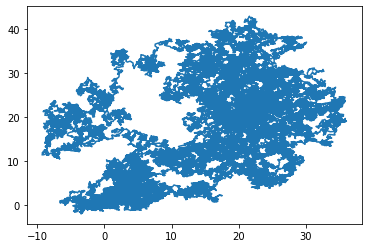

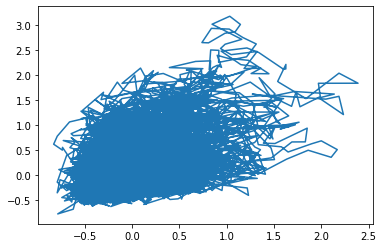

In [48]:
i = [i for i in js['uniform'] if my_data[i].stride == 100][0]

obj = my_data[i]
plt.plot(obj.traj[:, 0], obj.traj[:, 1])

plt.figure()
i = [i for i in js['jeffreys'] if my_data[i].stride == 100][0]

obj = my_data[i]

plt.plot(obj.traj[:, 0], obj.traj[:, 1])


In [63]:
len(js['uniform'])

19

In [69]:
data.mol['AAAA'].names

{'backbone1_gamma_3J': array([['0-1H5H4'],
        ['0-2H5H4'],
        ['1-1H5H4'],
        ['1-2H5H4'],
        ['2-1H5H4'],
        ['2-2H5H4'],
        ['3-1H5H4'],
        ['3-2H5H4']], dtype='<U7'),
 'backbone2_beta_epsilon_3J': array([['0-H3P'],
        ['1-1H5P'],
        ['1-2H5P'],
        ['1-H3P'],
        ['2-1H5P'],
        ['2-2H5P'],
        ['2-H3P'],
        ['3-1H5P'],
        ['3-2H5P']], dtype='<U6'),
 'sugar_3J': array([['0-H1H2'],
        ['0-H2H3'],
        ['0-H3H4'],
        ['1-H1H2'],
        ['1-H2H3'],
        ['1-H3H4'],
        ['2-H1H2'],
        ['2-H2H3'],
        ['2-H3H4'],
        ['3-H1H2'],
        ['3-H3H4']], dtype='<U6')}

KeyboardInterrupt: 

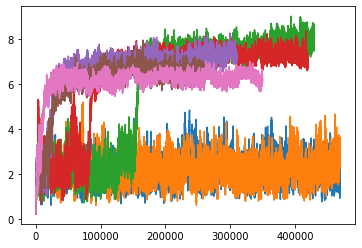

In [64]:
for i in js['uniform'][5:15]:
    plt.plot(my_data[i].dkl, label=int(my_data[i].stride))

plt.legend()

0.46188941189276495
0.46188941189276495


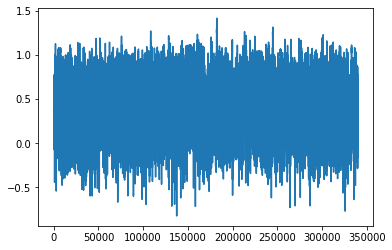

In [91]:
time_series = my_data[js['uniform'][0]].obs[:, 8]

plt.plot(time_series)

print(np.mean(time_series))

ind = detect_convergence(time_series)

print(np.mean(time_series[ind:]))

denormalize and plot also experimental and average values

In [ ]:
strides = [int(my_data[i].stride) for i in range(len(my_data))]

In [ ]:
path = 'normalized_values/normg_%s_AAAA_'

normg_mean = {}
normg_std = {}

for stride in strides:
    normg_mean[stride] = np.array(pandas.read_csv((path % 'mean') + str(stride), sep=' '))[0]
    normg_std[stride] = np.array(pandas.read_csv((path % 'std') + str(stride), sep=' '))[0]

In [35]:
for i in range(len(my_data)):
    stride = my_data[i].stride
    my_data[i].obs_avs = denormalize(my_data[i].obs_avs, normg_mean[stride], normg_std[stride])
    my_data[i].obs_stds = denormalize(my_data[i].obs_stds, None, normg_std[stride])
    

In [36]:
my_gexp = data.mol['AAAA'].gexp

g_exps = np.concatenate([my_gexp[s][:, 0] for s in my_gexp.keys()])
err_exps = np.concatenate([my_gexp[s][:, 1] for s in my_gexp.keys()])

!! mismatch between n. of Monte Carlo steps required (as in `df_pars[n_steps]`) and the real ones, as in `qs['plain'][0].shape[0]`

- with `'plain'` is almost the same over different strides, but with `J`?

so, let's stop at 1e5 steps, almost equal for all

In [95]:
vars(my_data[28]).keys()

dict_keys(['i', 'label', 'df', 'traj', 'n_steps_true', 'obs', 'dkl', 'loss', 'energy', 'if_detect_convergence', 'obs_inds', 'obs_avs', 'obs_stds', 'dkl_inds', 'dkl_avs', 'dkl_stds'])

In [80]:
[i for i in range(len(my_data)) if my_data[i].stride == 100 and my_data[i].which_measure == 0]

[28]

In [ ]:
vars(my_data[28])

0.26240964771455805

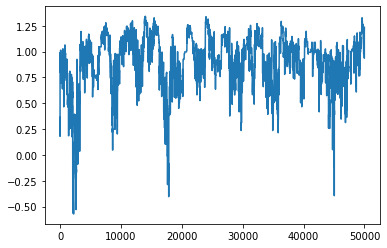

In [97]:
plt.plot(my_data[0].obs[:, 8])

np.std(my_data[0].obs[:, 8])

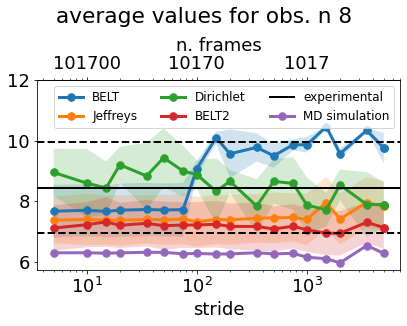

In [ ]:
my_types = js.keys()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ['BELT', 'Jeffreys', 'Dirichlet', 'BELT2']

# focus on observable n. 8 !!
n_obs = 8  # for n_obs in [8]:  # range(20):

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 18
plt.rcParams.update({'figure.autolayout': True})

fig, ax = plt.subplots(figsize=(6, 5))

for i, s in enumerate(my_types):  # ENSURE SAME ORDER OF MY_TYPES AND LABELS
    strides = [my_data[i].stride for i in js[s]]
    mus = np.array([my_data[i].obs_avs[n_obs] for i in js[s]])
    stds = np.array([my_data[i].obs_stds[n_obs] for i in js[s]])

    ax.plot(strides, mus, '.-', label=labels[i], c=colors[i], linewidth=3, markersize=15)
    ax.fill_between(strides, mus - stds, mus + stds, alpha=0.2)

ax.set_xscale('log')
xlim = plt.xlim()

ax.plot(xlim, g_exps[n_obs]*np.ones(2), '-k', label='experimental')
ax.plot(xlim, (g_exps[n_obs] + err_exps[n_obs])*np.ones(2), '--k')
ax.plot(xlim, (g_exps[n_obs] - err_exps[n_obs])*np.ones(2), '--k')

avgs = np.array([(stride, normg_mean[stride][n_obs]) for stride in np.unique(strides)])
ax.plot(avgs[:, 0], avgs[:, 1], '.-', label='MD simulation', c=colors[4], linewidth=3, markersize=15)

ax.set_xlim(xlim)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0], 12)

ax.legend(ncol=3, fontsize=12)
fig.suptitle('average values for obs. n %i' % n_obs, y=.92)
ax.set_xlabel('stride')

# Add top x-axis with same ticks
secax = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
secax.set_xlabel("n. frames")

# xtick_labels = np.array([float(tick.get_text()) for tick in ax.get_xticklabels()[1:-1]])
xtick_labels = [10, 100, 1000]

secax.set_xticks(ax.get_xticks(), [int(i) for i in n_frames[0]//ax.get_xticks()])

plt.tight_layout()
# plt.show()

# plt.savefig('Manuscript_images/3_final_comparison_obs_n8_skipeq.pdf', format='pdf', bbox_inches='tight')


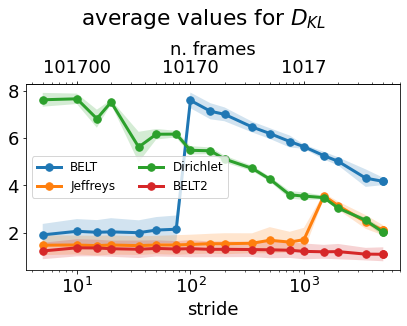

In [ ]:
my_types = js.keys()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ['BELT', 'Jeffreys', 'Dirichlet', 'BELT2']

# focus on observable n. 8 !!
n_obs = 8  # for n_obs in [8]:  # range(20):

fig, ax = plt.subplots(figsize=(6, 5))

for i, s in enumerate(my_types):  # ENSURE SAME ORDER OF MY_TYPES AND LABELS
    strides = [my_data[i].stride for i in js[s]]
    mus = np.array([my_data[i].dkl_avs for i in js[s]])
    stds = np.array([my_data[i].dkl_stds for i in js[s]])

    ax.plot(strides, mus, '.-', label=labels[i], c=colors[i], linewidth=3, markersize=15)
    ax.fill_between(strides, mus - stds, mus + stds, alpha=0.2)


ax.set_xscale('log')
xlim = plt.xlim()

ax.set_xlim(xlim)
ax.legend(ncol=2, fontsize=12)
fig.suptitle('average values for $D_{KL}$', y=.92)
ax.set_xlabel('stride')

# Add top x-axis with same ticks
secax = ax.secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
secax.set_xlabel("n. frames")

# xtick_labels = np.array([float(tick.get_text()) for tick in ax.get_xticklabels()[1:-1]])
xtick_labels = [10, 100, 1000]

secax.set_xticks(ax.get_xticks(), [int(i) for i in n_frames[0]//ax.get_xticks()])

plt.tight_layout()
# plt.show()

# plt.savefig('Manuscript_images/3_final_comparison_dkl_skipeq.pdf', format='pdf', bbox_inches='tight')


In [68]:
print(strides)

[5.0, 10.0, 15.0, 20.0, 35.0, 50.0, 75.0, 100.0, 150.0, 200.0, 350.0, 500.0, 750.0, 1000.0, 1500.0, 2000.0, 3500.0, 5000.0, 5000.0]


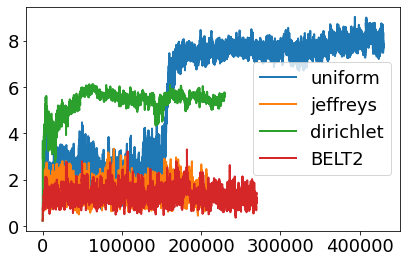

In [71]:
# focus on a given stride
stride = 100

for j in range(4):
    inds = [i for i in range(len(my_data)) if my_data[i].which_measure == j and my_data[i].stride == stride][0]

    plt.plot(my_data[inds].dkl, label=list(my_types)[j])

plt.legend()

dict_keys(['uniform', 'jeffreys', 'dirichlet', 'BELT2']) ['BELT', 'Jeffreys', 'Dirichlet', 'average'] match?


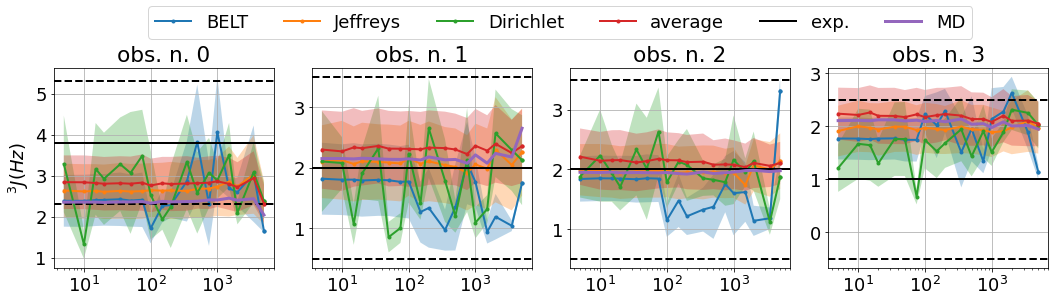

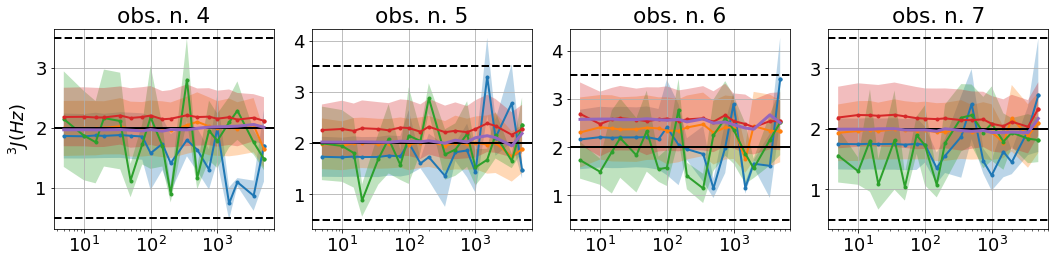

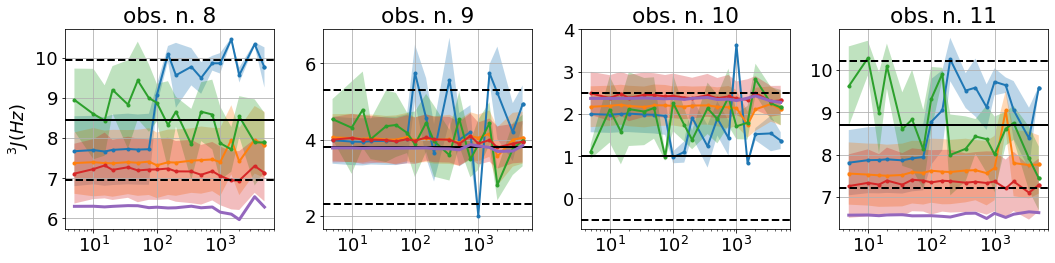

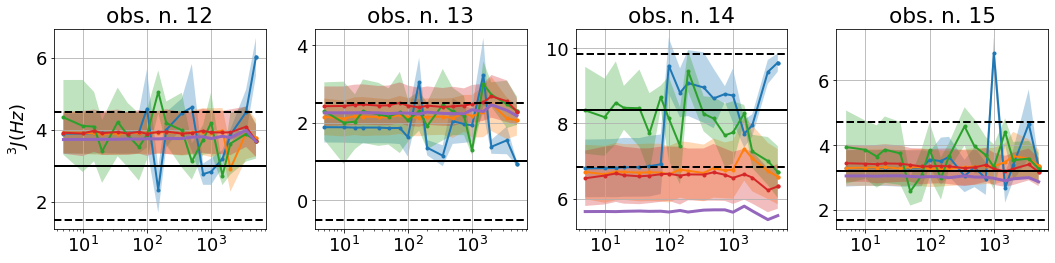

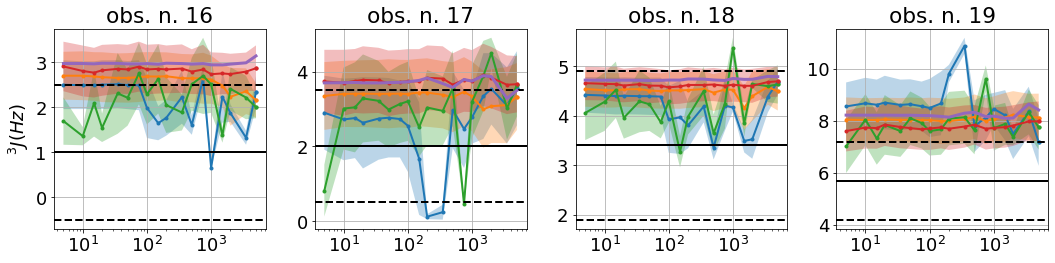

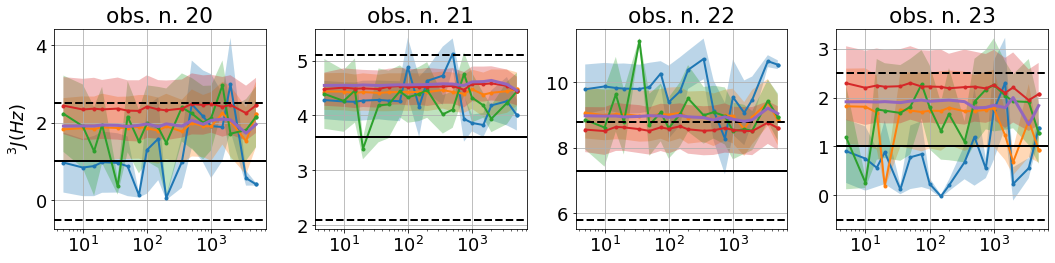

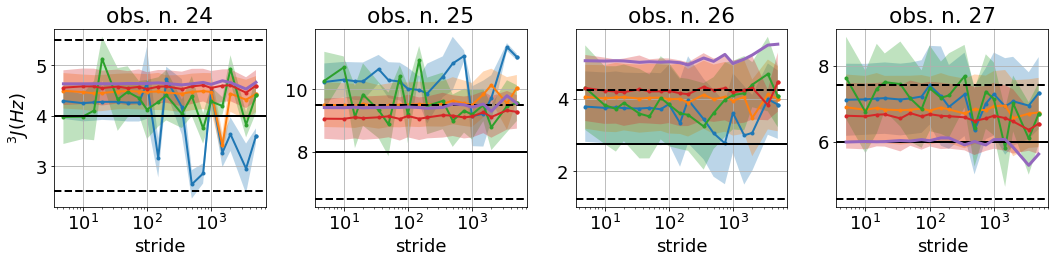

In [67]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 18
plt.rcParams.update({'figure.autolayout': True})

labels = ['BELT', 'Jeffreys', 'Dirichlet', 'average']
print(my_types, labels, 'match?')

tot_n_obs = my_data[0].obs.shape[1]  # -1 because the last two are the relative entropy and loss
n_cols = 4  # how many columns for each row

n_row = 0

for n_obs in range(tot_n_obs):

    n_col = np.mod(n_obs, n_cols)

    if n_col == 0: fig, axs = plt.subplots(1, n_cols, figsize=(15, 4))# , constrained_layout=True)

    for i, s in enumerate(my_types):
        strides = [my_data[i].stride for i in js[s]]
        mus = np.array([my_data[i].obs_avs[n_obs] for i in js[s]])
        stds = np.array([my_data[i].obs_stds[n_obs] for i in js[s]])
        
        axs[n_col].plot(strides, mus, '.-', label=labels[i], c=colors[i])
        # axs[n_col].errorbar(strides[s], mus[s][:, n_obs], yerr=stds[s][:, n_obs], c=colors[i], capsize=5)
        axs[n_col].fill_between(strides, mus - stds, mus + stds, alpha=0.3)

    axs[n_col].set_xscale('log')
    xlim = axs[n_col].get_xlim()

    axs[n_col].plot(xlim, g_exps[n_obs]*np.ones(2), '-k', label='exp.')
    axs[n_col].plot(xlim, (g_exps[n_obs] + err_exps[n_obs])*np.ones(2), '--k')
    axs[n_col].plot(xlim, (g_exps[n_obs] - err_exps[n_obs])*np.ones(2), '--k')

    avgs = np.array([(stride, normg_mean[stride][n_obs]) for stride in np.unique(strides)])
    axs[n_col].plot(avgs[:, 0], avgs[:, 1], label='MD', c=colors[4], linewidth=3)

    axs[n_col].set_title('obs. n. %i' % n_obs)
    axs[n_col].set_xlim(xlim)
    axs[n_col].grid()

    if n_col == 0: axs[n_col].set_ylabel(r'$^3 J (Hz)$')
    if n_row == (tot_n_obs//n_cols - 1): axs[n_col].set_xlabel('stride')
    
    if n_row == 0 and n_col == 0: fig.legend(ncol=6, bbox_to_anchor=(0.92, 1.1))

    if np.mod(n_obs, n_cols) == 3: plt.savefig('Manuscript_images/3_final_comparison_%i_skipeq.pdf' % n_row, format='pdf', bbox_inches='tight')

    if n_col == (n_cols - 1): n_row += 1

In [ ]:
print(np.unique(strides['plain']))

[   5   10   15   20   35   50   75  100  150  200  350  500  750 1000
 1500 2000 3500 5000]


Text(0.5, 1.0, 'obs. n. 8')

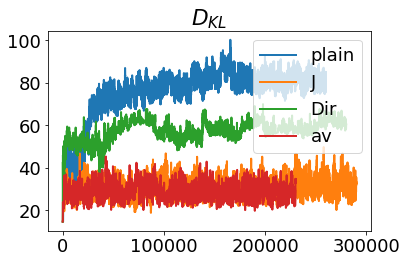

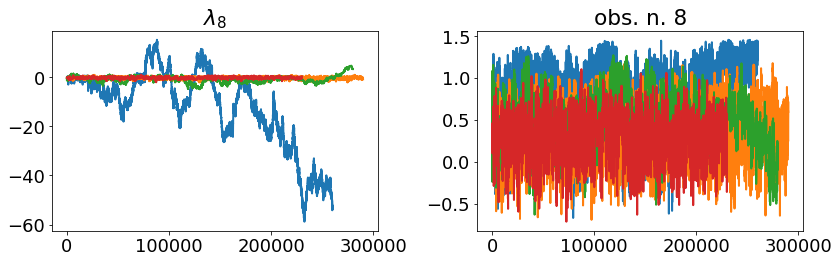

In [ ]:
stride = 350

for s in strides.keys():
    i = np.argwhere(np.array(strides[s]) == stride)[0][0]
    plt.plot(qs[s][i][:, -1], label=s)
plt.legend()
plt.title(r'$D_{KL}$')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
j = 8
for s in strides.keys():
    i = np.argwhere(np.array(strides[s]) == stride)[0][0]
    axs[0].plot(trajs[s][i][:, j])
    axs[1].plot(qs[s][i][:, j])

axs[0].set_title('$\lambda_%i$' % j)
axs[1].set_title('obs. n. %i' % j)




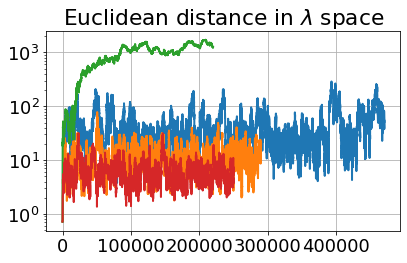

In [ ]:
plt.figure()

stride = 75

for s in strides.keys():
    i = np.argwhere(np.array(strides[s]) == stride)[0][0]
    euclid_dist = np.sum(trajs[s][i]**2, axis=1)
    plt.plot(euclid_dist, label=s)

plt.title('Euclidean distance in $\lambda$ space')
plt.yscale('log')
plt.grid()

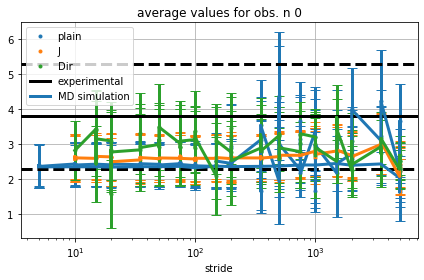

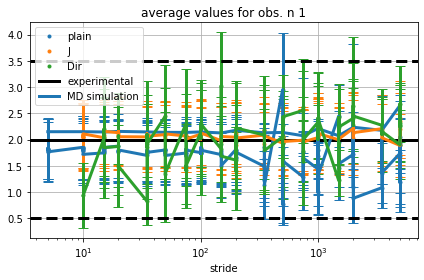

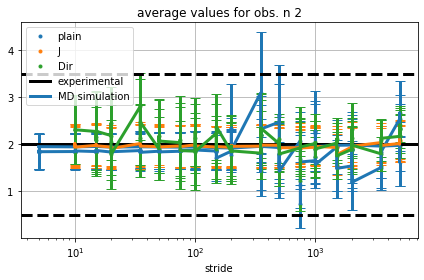

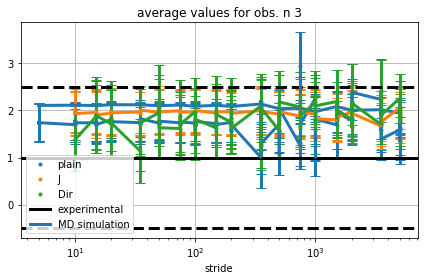

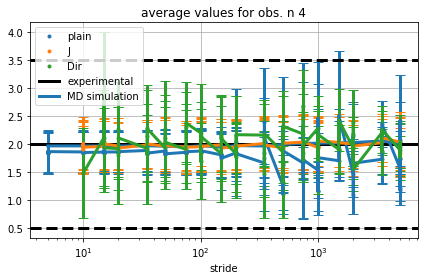

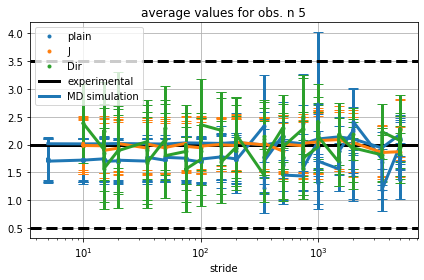

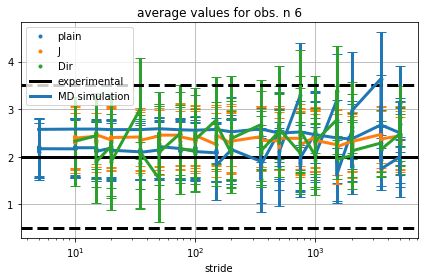

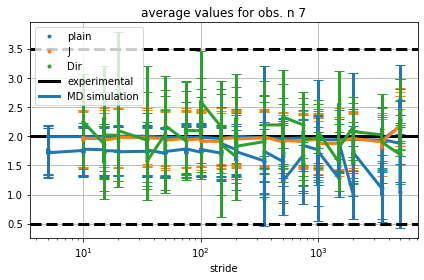

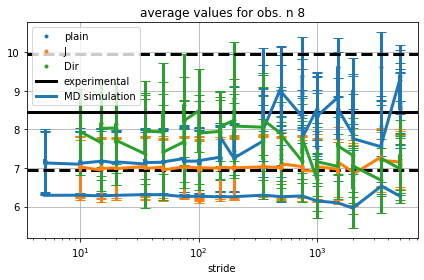

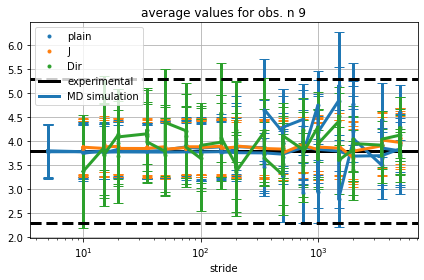

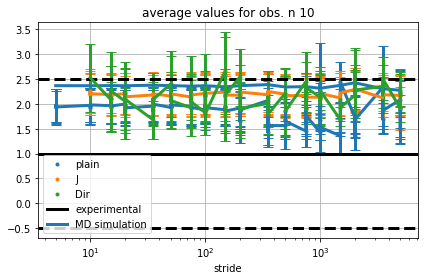

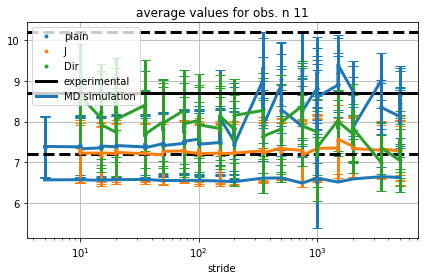

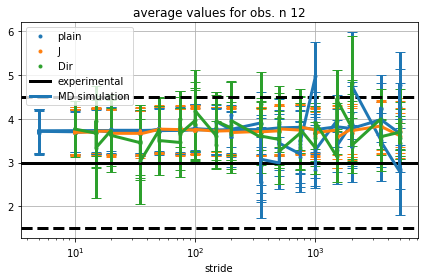

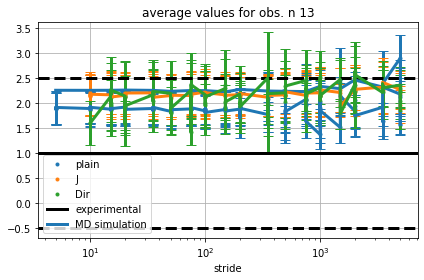

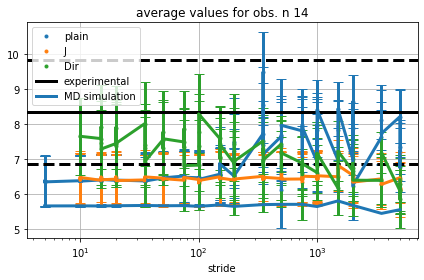

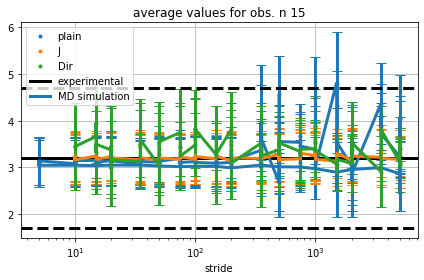

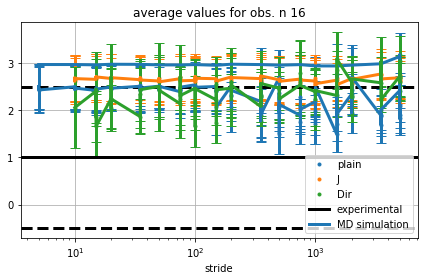

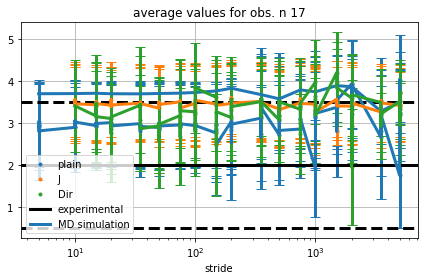

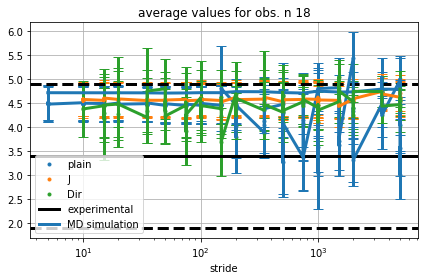

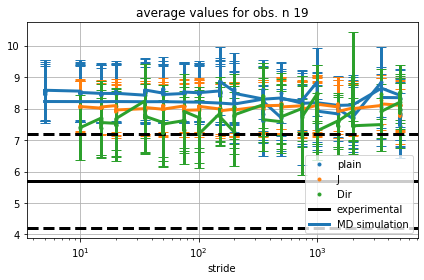

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

# my_types = ['plain', 'J']

for n_obs in range(20):

    plt.figure()

    # focus on observable n. 8 !!
    for i, s in enumerate(my_types):
        plt.plot(strides[s], mus[s][:, n_obs], '.', label=s, c=colors[i])
        plt.errorbar(strides[s], mus[s][:, n_obs], yerr=stds[s][:, n_obs], c=colors[i], capsize=5)

    plt.xscale('log')
    xlim = plt.xlim()

    plt.plot(xlim, g_exps[n_obs]*np.ones(2), '-k', label='experimental')
    plt.plot(xlim, (g_exps[n_obs] + err_exps[n_obs])*np.ones(2), '--k')
    plt.plot(xlim, (g_exps[n_obs] - err_exps[n_obs])*np.ones(2), '--k')

    avgs = np.array([(stride, normg_mean[stride][n_obs]) for stride in np.unique(strides['plain'])])
    plt.plot(avgs[:, 0], avgs[:, 1], label='MD simulation')

    plt.xlim(xlim)
    plt.grid()
    plt.title('average values for obs. n %i' % n_obs)
    plt.xlabel('stride')
    plt.legend()